In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display_html
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
output_path = './output/consis_on_exc/'
input_path = './output/exclude/'
try:
    _=os.listdir(output_path)
except:
    os.mkdir(output_path)
from data_loader_exclude import load_data_default
#clfs = [i for i in os.listdir('./output/exclude/') if 'csv' not in i]
clfs = ['DA_lgbm_t_series', 'DA_ADA_t_series', 'DA_rf_t_series', 'DA_gboost_t_series']
print(clfs)

['DA_lgbm_t_series', 'DA_ADA_t_series', 'DA_rf_t_series', 'DA_gboost_t_series']


# Data Augmentaion

In [2]:
load_data = load_data_default()
df,y = load_data.load_train_data()
print(df.shape,df.loc[y==1].shape)
i,_ =df.shape
j,_ =df.loc[y==1].shape
print(f'Ratio of default is {round(j/i,3)}\n')

(22500, 24) (4977, 24)
Ratio of default is 0.221



In [3]:
1-0.221

0.779

## About 78percents of samples are duly paying

![title](img/Distribution_of_default.png)

## Last time, we've checked that consistently incorrect samples were mostly defaults






### Thereby having suspection on weak learning on default samples tried data augmentation on samples with default:

```python
class PositivePerturb():
    def __init__(self, random_state=None,dup_num=1):
        self.random_state = random_state
        self.dup_num = dup_num
    def fit(self, X, y):
        return self
    
    def transform(self, X, y):
        BILL = load_data.BILL.copy()
        BILL.pop(0)
        PAY = load_data.PAY.copy()
        PAY.pop(-1)
        rng = np.random.default_rng(self.random_state)
        X_transform = X.copy()
        y_transform = y.copy()
        for i in range(self.dup_num):
            X_aug, y_aug = X.loc[y==1].copy(), y.loc[y==1].copy()
            X_aug[BILL] *= (0.9 + 0.2*rng.random(X_aug[BILL].shape))
            X_aug[BILL] = X_aug[BILL].astype('int')
            X_aug['ID'] += 30000*(i+1)+1
            y_aug.index += 30000*(i+1)+1
            pay_perturb=(X_aug[BILL]-X.loc[y==1][BILL]).to_numpy()
            X_aug[PAY] += pay_perturb
            X_transform = pd.concat([X_transform, X_aug], axis=0, ignore_index=True)
            y_transform = pd.concat([y_transform, y_aug], axis=0, ignore_index=False)
        return X_transform,y_transform
```

In [4]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,RocCurveDisplay
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from data_loader_default import load_data_default


def my_score(y_train,y_pred):
    accuracy = accuracy_score(y_train,y_pred)
    pre_score = precision_score(y_train,y_pred)
    rec_score = recall_score(y_train,y_pred)
    f_score = f1_score(y_train,y_pred)

    return [round(accuracy,4), round(pre_score,4), round(rec_score ,4), round(f_score,4)]




X_train,y_train,X_val,y_val = 0,0,0,0
load_data = load_data_default()


In [5]:
DA_score_df_by_clf = []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        DA_score_df_by_clf.append(evals_frame)
NDA_score_df_by_clf = []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        NDA_score_df_by_clf.append(evals_frame)
for i in range(3):
    df1 = DA_score_df_by_clf[i]
    df2 = NDA_score_df_by_clf[i]
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Data Augmented')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Original')
    display_html(df1_styler._repr_html_()+'\xa0'*8+df2_styler._repr_html_(), raw=True)
    print('\n\n\n')

,clf,acc,prec,rec,f1,roc_auc
0,DA_lgbm_t_series,0.793100,0.537100,0.465300,0.498700,0.750600
1,DA_lgbm_t_series,0.791300,0.532600,0.459300,0.493300,0.744100
2,DA_lgbm_t_series,0.794400,0.542500,0.449200,0.491500,0.751000
3,DA_lgbm_t_series,0.787300,0.521400,0.477900,0.498700,0.745000
4,DA_lgbm_t_series,0.804900,0.571800,0.471900,0.517100,0.769900
,clf,acc,prec,rec,f1,roc_auc
0,DA_lgbm_t_series,0.824000,0.722100,0.331700,0.454500,0.776900
1,DA_lgbm_t_series,0.818000,0.697300,0.312600,0.431600,0.768100
2,DA_lgbm_t_series,0.818400,0.696000,0.317600,0.436200,0.780100
3,DA_lgbm_t_series,0.820000,0.696200,0.331300,0.449000,0.769200


,clf,acc,prec,rec,f1,roc_auc
0,DA_ADA_t_series,0.782900,0.508900,0.518600,0.513700,0.749100
1,DA_ADA_t_series,0.792400,0.537200,0.442200,0.485100,0.743700
2,DA_ADA_t_series,0.780000,0.502600,0.486400,0.494400,0.745100
3,DA_ADA_t_series,0.779800,0.502400,0.522100,0.512100,0.747500
4,DA_ADA_t_series,0.800900,0.562200,0.453800,0.502200,0.766600
,clf,acc,prec,rec,f1,roc_auc
0,DA_ADA_t_series,0.823600,0.728900,0.321600,0.446300,0.754800
1,DA_ADA_t_series,0.818700,0.696700,0.318600,0.437200,0.753200
2,DA_ADA_t_series,0.818200,0.698900,0.312600,0.431900,0.750000
3,DA_ADA_t_series,0.818200,0.680900,0.336300,0.450300,0.760700


,clf,acc,prec,rec,f1,roc_auc
0,DA_rf_t_series,0.796000,0.539900,0.523600,0.531600,0.755900
1,DA_rf_t_series,0.794400,0.538100,0.496500,0.516500,0.751600
2,DA_rf_t_series,0.794000,0.538100,0.482400,0.508700,0.755900
3,DA_rf_t_series,0.785600,0.515700,0.510000,0.512900,0.748600
4,DA_rf_t_series,0.806200,0.566700,0.529100,0.547200,0.773800
,clf,acc,prec,rec,f1,roc_auc
0,DA_rf_t_series,0.822000,0.683000,0.363800,0.474800,0.778600
1,DA_rf_t_series,0.816000,0.664700,0.338700,0.448700,0.771600
2,DA_rf_t_series,0.810000,0.646400,0.310600,0.419600,0.779200
3,DA_rf_t_series,0.819300,0.666700,0.367500,0.473800,0.769300


## We see increase on recall but decrease on accuracy

In [6]:
pd.concat(DA_score_df_by_clf,axis=0)

,clf,acc,prec,rec,f1,roc_auc
0,DA_lgbm_t_series,0.7931,0.5371,0.4653,0.4987,0.7506
1,DA_lgbm_t_series,0.7913,0.5326,0.4593,0.4933,0.7441
2,DA_lgbm_t_series,0.7944,0.5425,0.4492,0.4915,0.751
3,DA_lgbm_t_series,0.7873,0.5214,0.4779,0.4987,0.745
4,DA_lgbm_t_series,0.8049,0.5718,0.4719,0.5171,0.7699
0,DA_ADA_t_series,0.7829,0.5089,0.5186,0.5137,0.7491
1,DA_ADA_t_series,0.7924,0.5372,0.4422,0.4851,0.7437
2,DA_ADA_t_series,0.78,0.5026,0.4864,0.4944,0.7451
3,DA_ADA_t_series,0.7798,0.5024,0.5221,0.5121,0.7475
4,DA_ADA_t_series,0.8009,0.5622,0.4538,0.5022,0.7666


## EDA

In [7]:
from data_loader_exclude import load_data_default as load_data_exclude

In [8]:
load_data =load_data_exclude(exclude=True)

In [9]:
DA_score_df_by_clf = []
for clf in clfs:
        output_path = f'./output/exclude/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        DA_score_df_by_clf.append(evals_frame)
NDA_score_df_by_clf = []
for clf in clfs:
        output_path = f'./output/exclude/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        NDA_score_df_by_clf.append(evals_frame)
for i in range(4):
    df1 = DA_score_df_by_clf[i]
    df2 = NDA_score_df_by_clf[i]
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Data Augmented')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Original')
    display_html(df1_styler._repr_html_()+'\xa0'*8+df2_styler._repr_html_(), raw=True)
    print('\n\n\n')

,clf,acc,prec,rec,f1,roc_auc
0,DA_lgbm_t_series,0.847700,0.614900,0.484400,0.541900,0.823500
1,DA_lgbm_t_series,0.847700,0.615300,0.483100,0.541300,0.831900
2,DA_lgbm_t_series,0.850000,0.631600,0.464400,0.535300,0.824200
3,DA_lgbm_t_series,0.843000,0.599000,0.471900,0.527900,0.812200
4,DA_lgbm_t_series,0.853000,0.639100,0.481900,0.549500,0.832400
,clf,acc,prec,rec,f1,roc_auc
0,DA_lgbm_t_series,0.858600,0.682500,0.448200,0.541100,0.835200
1,DA_lgbm_t_series,0.857400,0.669700,0.460700,0.545900,0.845500
2,DA_lgbm_t_series,0.859000,0.692500,0.435700,0.534900,0.840300
3,DA_lgbm_t_series,0.848500,0.639300,0.427000,0.512000,0.830900


,clf,acc,prec,rec,f1,roc_auc
0,DA_ADA_t_series,0.858100,0.714900,0.394500,0.508400,0.823400
1,DA_ADA_t_series,0.859700,0.710000,0.415700,0.524400,0.824600
2,DA_ADA_t_series,0.856200,0.704000,0.392000,0.503600,0.823700
3,DA_ADA_t_series,0.851100,0.671700,0.390800,0.494100,0.803300
4,DA_ADA_t_series,0.859500,0.717800,0.403200,0.516400,0.831100
,clf,acc,prec,rec,f1,roc_auc
0,DA_ADA_t_series,0.859000,0.746200,0.367000,0.492100,0.827400
1,DA_ADA_t_series,0.858600,0.716200,0.397000,0.510800,0.831700
2,DA_ADA_t_series,0.857200,0.733700,0.364500,0.487100,0.830700
3,DA_ADA_t_series,0.851300,0.687600,0.368300,0.479700,0.818400


,clf,acc,prec,rec,f1,roc_auc
0,DA_rf_t_series,0.848800,0.615400,0.499400,0.551300,0.818100
1,DA_rf_t_series,0.855100,0.638900,0.508100,0.566100,0.827900
2,DA_rf_t_series,0.852800,0.634900,0.490600,0.553500,0.817700
3,DA_rf_t_series,0.845300,0.601500,0.499400,0.545700,0.796500
4,DA_rf_t_series,0.854600,0.636500,0.509400,0.565900,0.825300
,clf,acc,prec,rec,f1,roc_auc
0,DA_rf_t_series,0.854600,0.677500,0.417000,0.516200,0.835100
1,DA_rf_t_series,0.861600,0.697500,0.451900,0.548500,0.841300
2,DA_rf_t_series,0.857200,0.687500,0.425700,0.525800,0.833000
3,DA_rf_t_series,0.851300,0.653300,0.428200,0.517300,0.822000


,clf,acc,prec,rec,f1,roc_auc
0,DA_gboost_t_series,0.855600,0.684500,0.414500,0.516300,0.828300
1,DA_gboost_t_series,0.857600,0.694200,0.419500,0.523000,0.829600
2,DA_gboost_t_series,0.854200,0.688500,0.394500,0.501600,0.828700
3,DA_gboost_t_series,0.846900,0.645500,0.393300,0.488800,0.805000
4,DA_gboost_t_series,0.856400,0.695900,0.405700,0.512600,0.832100
,clf,acc,prec,rec,f1,roc_auc
0,DA_gboost_t_series,0.860900,0.716700,0.417000,0.527200,0.833600
1,DA_gboost_t_series,0.861400,0.708200,0.433200,0.537600,0.832700
2,DA_gboost_t_series,0.859500,0.720700,0.399500,0.514100,0.835800
3,DA_gboost_t_series,0.853700,0.678500,0.405700,0.507800,0.823900


In [10]:
prediction_list = []
for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
    X_train ,y_train, X_val, y_val = X_train ,y_train, X_val, y_val
    preds_by_clf = [y_val]
    for clf in clfs:
        output_path = f'./output/exclude/{clf}/'
        pred = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv', index_col=0)
        pred.columns = [clf]
        preds_by_clf.append(pred.set_index(y_val.index))
    prediction_list.append(pd.concat(preds_by_clf,axis=1))

pred_df =pd.concat(prediction_list,axis=0)

In [11]:
wrong =pred_df.apply(lambda x :abs(x-pred_df.default), axis=0)
wrong_sum =wrong.sum(axis=1)

Total 4 classifying was executed
Following are analysis of consistently wrong samples


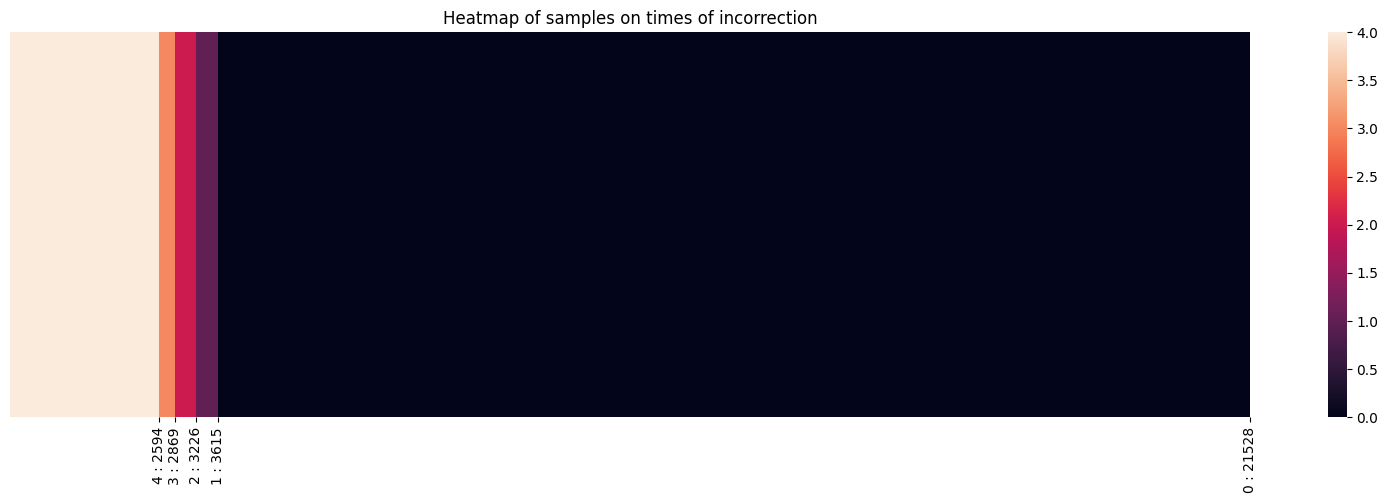

In [12]:
n = wrong.shape[1]-1
print(f'Total {n} classifying was executed\nFollowing are analysis of consistently wrong samples')

import seaborn as sns
fig, ax = plt.subplots(figsize=(20,5))
freq_for_heat =wrong_sum.sort_values(ascending=False).to_numpy().reshape(1,-1)
sns.heatmap(freq_for_heat,vmax=n)
x_ticks =[wrong_sum[wrong_sum>j-1].shape[0] for j in [4,3,2,1,0]]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{freq} : {count}' for count,freq in zip(x_ticks,[4,3,2,1,0])])
ax.set_yticks([])
ax.set_title('Heatmap of samples on times of incorrection')
plt.show()
plt.close()

In [13]:
cons_wrong_idc =wrong_sum[wrong_sum>3].index

df =load_data.df_train
df_original = pd.concat(list(load_data.load_train_data()),axis=1)

cons_wrong =df_original.loc[cons_wrong_idc]

print(f'mean of consistently wrong samples = {round(cons_wrong.default.mean(),4)}')

print(f'mean of every incorrenct samples = {df_original.loc[wrong_sum[wrong_sum>0].index].default.mean()}')

incorrect_means = [df_original.loc[wrong_sum[wrong_sum>i].index].default.mean() for i in np.arange(0,4)]

mean of consistently wrong samples = 0.803
mean of every incorrenct samples = 0.7255878284923928


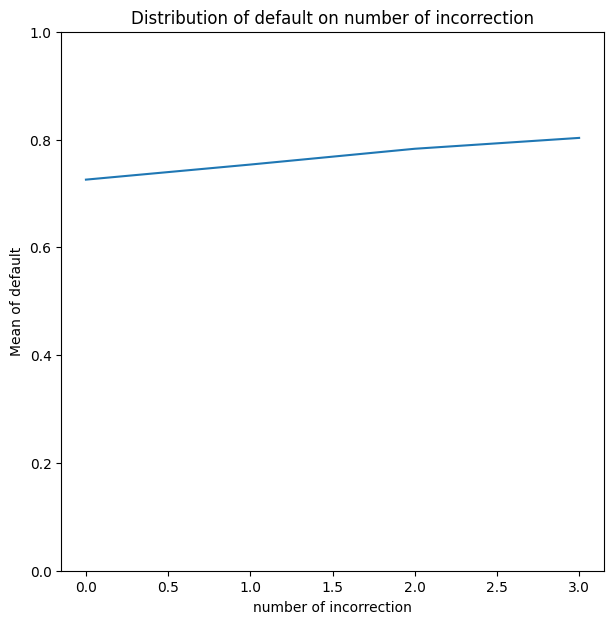

In [14]:
fig ,ax = plt.subplots(figsize=(7,7))
ax.plot(np.arange(0,4),incorrect_means)
ax.set_ylim(0,1)
ax.set_ylabel('Mean of default')
ax.set_xlabel('number of incorrection')
ax.set_title('Distribution of default on number of incorrection')
plt.show()
plt.close()

In [15]:
output_path = './output/DA_EXC/' 
try:
    _=os.listdir(output_path)
except:
    os.mkdir(output_path)


In [16]:
for i in range(4):
    cons_wrong_idc = wrong_sum[wrong_sum>i].index
    cons_wrong = df_original.loc[cons_wrong_idc]
    cons_wrong.to_csv(output_path+f'{i}-times_wrong_samples.csv')